<a href="https://colab.research.google.com/github/JorgeSC98/COVIDPredictions-RNN/blob/main/COVID_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID Death Cases Prediction with RNN

###  Authors
Jorge Sáenz, Omar Muñoz, Elias Villalvazo, Israel Cárdenas, Luis Deutsch. 


## Summary

COVID-19 has been a situation that has generated tons of data every day from infections to vaccination rates worldwide. This paper will present the preprocessing, classification, and comparison of three different RNN architectures applied to a COVID-19 dataset from Mexico in order to predict death cases over months, providing the best hyperparameters found for each model.

# Methodology

## Data preprocessing

"Our World in Data" is an online publication in collaboration with The University of Oxford that provides a reliable repository of datasets about dozens of topics focusing on those big problems which affect the world.

The used [dataset](https://ourworldindata.org/covid-vaccinations) is a collection of data from every country in the world related to the COVID-19 outbreak. This dataset is updated every day for all countries, allowing a better traceability. Additionally, it contains multiple indicators which can lead to take better decisions.

A more-detailed description of the variables from this dataset can be obtained from the [GitHub](https://github.com/owid/covid-19-data/blob/master/public/data/README.md) reposotiry of the project.

In [ ]:
from google.colab            import files
from google.colab            import drive
from os.path                 import isfile, join
from os                      import listdir

import numpy                 as np
import pandas                as pd

from sklearn.preprocessing   import StandardScaler

drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Keep data of interest**

For the sake of this work, we will only keep data from Mexico and will apply basic filtering, such as the removal of NULL columns and non-numeric data.

In [ ]:
path     = '/content/gdrive/MyDrive/Machine_Learning/COVID-DeathCases-Prediction/'
filename = 'owid-covid-data.csv'
df       = pd.read_csv(path + filename)

# Keep data from Mexico only
countries_of_interest = ['Mexico']
df_filtered = df[df['location'].isin(countries_of_interest)]

# Drop columns where all data is NULL
df_filtered = df_filtered.dropna(how='all', axis=1)

# Keep numeric features only
df_filtered = df_filtered.select_dtypes(include=['float64'])

In [ ]:
df.loc[df.location == "Mexico"]

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
106147,MEX,North America,Mexico,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,...,6.9,21.4,87.847,1.38,75.05,0.779,NaN,NaN,NaN,NaN
106148,MEX,North America,Mexico,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,...,6.9,21.4,87.847,1.38,75.05,0.779,NaN,NaN,NaN,NaN
106149,MEX,North America,Mexico,2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,...,6.9,21.4,87.847,1.38,75.05,0.779,NaN,NaN,NaN,NaN
106150,MEX,North America,Mexico,2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,...,6.9,21.4,87.847,1.38,75.05,0.779,NaN,NaN,NaN,NaN
106151,MEX,North America,Mexico,2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,...,6.9,21.4,87.847,1.38,75.05,0.779,-78.5,-0.47,-0.47,-0.602631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106990,MEX,North America,Mexico,2022-04-23,5733428.0,1793.0,965.714,324120.0,87.0,26.000,...,6.9,21.4,87.847,1.38,75.05,0.779,NaN,NaN,NaN,NaN
106991,MEX,North America,Mexico,2022-04-24,5733785.0,357.0,873.857,324129.0,9.0,26.429,...,6.9,21.4,87.847,1.38,75.05,0.779,NaN,NaN,NaN,NaN
106992,MEX,North America,Mexico,2022-04-25,5733925.0,140.0,893.857,324134.0,5.0,27.143,...,6.9,21.4,87.847,1.38,75.05,0.779,NaN,NaN,NaN,NaN
106993,MEX,North America,Mexico,2022-04-26,5735115.0,1190.0,835.000,324173.0,39.0,28.571,...,6.9,21.4,87.847,1.38,75.05,0.779,NaN,NaN,NaN,NaN


**Add idenpendent variable**

Add a column for the days since the beginning of the data capture. This will serve as the independent variable for our regression.

In [ ]:
df_filtered['days'] = df_filtered.reset_index().index.astype(np.float64)

**Remove non-smoothed data**

In this section we show an example of two columns that represent the same variable. However, one of the columns is a smoothed out version of the other. We decided to keep the smoothed version as it captures the underlying trend of the data and it filters out a lot of the noise.

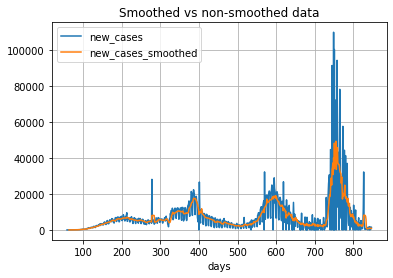

In [ ]:
# Plot new cases vs new cases smoothed
ax = df_filtered[["days", "new_cases", "new_cases_smoothed"]].plot(x="days", grid=True, title='Smoothed vs non-smoothed data')

In [ ]:
non_smoothed_data = ['new_cases','new_deaths','new_tests','new_cases_per_million','new_deaths_per_million','new_tests_per_thousand','new_vaccinations']
df_filtered       = df_filtered.drop(columns=non_smoothed_data)

**Interpolate data with missing values**

In some cases, data presents missing values that can be easily interpolated. Below there are a few examples.

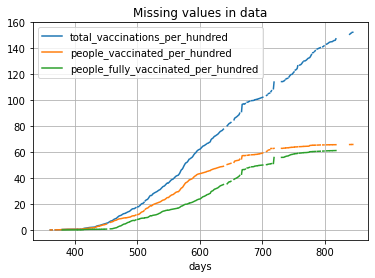

In [ ]:
# Example of missing values
df_filtered[["days", "total_vaccinations_per_hundred", "people_vaccinated_per_hundred", "people_fully_vaccinated_per_hundred"]].plot(x="days", grid=True, title='Missing values in data')

In [ ]:
# Apply interpolation
df_filtered2 = df_filtered.interpolate()

# Remove negative values which are an artifact of the interpolation process
column_names              = list(df_filtered2.columns.values)
valid_negative_value_cols = ['excess_mortality_cumulative_absolute','excess_mortality_cumulative','excess_mortality','excess_mortality_cumulative_per_million']

non_negative_cols               = list(set(column_names) - set(valid_negative_value_cols))
df_filtered2[non_negative_cols] = df_filtered2[non_negative_cols].clip(lower=0)

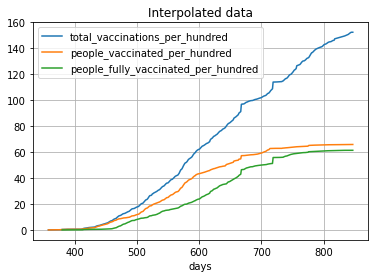

In [ ]:
# Show the results of the interpolation
df_filtered2[["days", "total_vaccinations_per_hundred", "people_vaccinated_per_hundred", "people_fully_vaccinated_per_hundred"]].plot(x="days", grid=True, title='Interpolated data')

**Replace missing values with zeros**

The interpolation settings chosen didn't interpolate missing values at the beginning of the data. Instead of interpolating missing values at the beginning of the data we replace it with zeros. Features such as "total_cases" have missing values in the beginning since there were no infections during the first months.

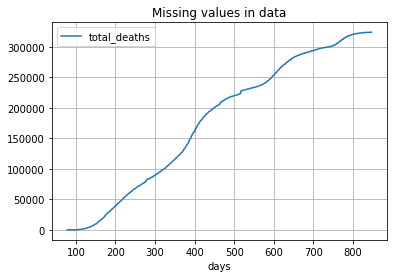

In [ ]:
# Example of missing data at the beginning of the data
df_filtered2[["days", "total_deaths"]].plot(x="days", grid=True, title='Missing values in data')

In [ ]:
df_filtered2 = df_filtered2.fillna(0)

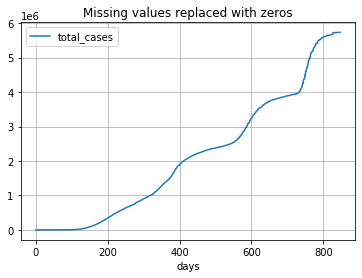

In [ ]:
# Result after filling the missing data with zeros
df_filtered2[["days", "total_cases"]].plot(x="days", grid=True, title='Missing values replaced with zeros')

**Feature normalization**

To avoid issues during the model fitting stage due to the different scales of the features, we apply a normalization to all of them.

In [ ]:
sc = StandardScaler()

# Apply data standarization to all of the filtered data
X  = sc.fit_transform(df_filtered2)

# Rebuild the dataframe
columns               = { i : column_names[i] for i in range( len( column_names ) ) }
df_normalized         = pd.DataFrame(X).rename(columns = columns)

# Rebuild the days column (QUESTION: Should we normalize the day vector?)
# df_normalized['days'] = df_normalized.reset_index().index.astype(np.float64)

In [ ]:
df_filtered2.head()

,total_cases,new_cases_smoothed,total_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,total_tests,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,days
106147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,...,21.4,87.847,1.38,75.05,0.779,0.0,0.00,0.00,0.000000,0.0
106148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97.0,...,21.4,87.847,1.38,75.05,0.779,0.0,0.00,0.00,0.000000,1.0
106149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,186.0,...,21.4,87.847,1.38,75.05,0.779,0.0,0.00,0.00,0.000000,2.0
106150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,231.0,...,21.4,87.847,1.38,75.05,0.779,0.0,0.00,0.00,0.000000,3.0
106151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,312.0,...,21.4,87.847,1.38,75.05,0.779,-78.5,-0.47,-0.47,-0.602631,4.0


In [ ]:
df_normalized.head()

,total_cases,new_cases_smoothed,total_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,total_tests,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,days
0,-1.182042,-0.921967,-1.395029,-1.32027,-1.182042,-0.921966,-1.395029,-1.320276,-2.577249,-1.154623,...,3.552714e-15,0.0,2.220446e-16,1.421085e-14,-1.110223e-16,-1.503336,-1.901628,-0.852539,-1.503336,-1.730009
1,-1.182042,-0.921967,-1.395029,-1.32027,-1.182042,-0.921966,-1.395029,-1.320276,-2.577249,-1.154609,...,3.552714e-15,0.0,2.220446e-16,1.421085e-14,-1.110223e-16,-1.503336,-1.901628,-0.852539,-1.503336,-1.725924
2,-1.182042,-0.921967,-1.395029,-1.32027,-1.182042,-0.921966,-1.395029,-1.320276,-2.577249,-1.154591,...,3.552714e-15,0.0,2.220446e-16,1.421085e-14,-1.110223e-16,-1.503336,-1.901628,-0.852539,-1.503336,-1.721839
3,-1.182042,-0.921967,-1.395029,-1.32027,-1.182042,-0.921966,-1.395029,-1.320276,-2.577249,-1.154582,...,3.552714e-15,0.0,2.220446e-16,1.421085e-14,-1.110223e-16,-1.503336,-1.901628,-0.852539,-1.503336,-1.717754
4,-1.182042,-0.921967,-1.395029,-1.32027,-1.182042,-0.921966,-1.395029,-1.320276,-2.577249,-1.154566,...,3.552714e-15,0.0,2.220446e-16,1.421085e-14,-1.110223e-16,-1.503677,-1.929585,-0.864674,-1.503677,-1.713669


## Regression models

### Recurrent Neural Networks (RNN)

Recurrent Neural Networks (RNN) are a variant of neural networks that are heavily used for Natural Language Processing and Sequential Data.
This class of neural networks allows previous outputs to be used as inputs, while having hidden states. Additionally, these networks add the concept of "memory", which consists of remembering all information about what has been calculated until time step *t*. 

RNNs are called "recurrent" because they perform the same task for every element of a sequence, with the output being dependent of previous computations.

Compared to a traditional neural network that receives an input at the input layer and it is further processed through a number of hidden layers, and finally, a final output is generated for input t, and that two successive inputs are independent of each other, a recurrent neural network, in contrast, considers that inputs are sequential and there is a relationship between inputs t and input at timestep t-1.

For instance, when predicting the price of a stock market at a given time, or when attempting to predict the next word in a sequence, it is imperative to consider previous observations. There are multiple cases where the sequence of information determines the event itself.

The equation for a single neuron in a RNN is given by:

$h_{t} = f(W_{h}^{T}h_{t-1} + W_{x}^{T}X_{T} + b_{h})$

Where:
- f is the activation function
- $W_{h}$ are the weights for the feedback loop
- $h_{t-1}$ is the response from the previous state
- $W_{x}$ is the weight matrix
- $b_{h}$ is the bias term

Unlike a traditional deep neural network, RNN converts the independent activations into dependent activations by providing the same weights and biases to all the layers. This reflects the fact that we are performing the same task at each step, just with different inputs.
This reduces the total number of parameters we need to learn.

The main feature of an RNN is its hidden state, which captures some information about a sequence.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import mean_squared_log_error
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
import math

In [ ]:
new_df = df_normalized[ 'new_deaths_smoothed' ].copy()

Define the window of the RNN model and training set at 80%:

In [ ]:
window = 10
train_len = math.ceil( len(new_df) * 0.8 )
train_data = new_df[ 0 : train_len]

X_train = [ train_data[ i - window : i] for i in range( window, len(train_data) ) ]
Y_train = [ train_data[ i ]             for i in range( window, len(train_data) ) ]

X_train, Y_train= np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

Define validation set at remaining 20%

In [ ]:
test_data = new_df[ train_len - window: ]

X_val=[ test_data[ i - window : i] for i in range( window, len(test_data) ) ]
Y_val=[ test_data[ train_len - window + i] for i in range( window, len(test_data) ) ] 

X_val, Y_val = np.array(X_val), np.array(Y_val)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))

Build the RNN network and train with proper set: 

In [ ]:
def RNN_model(X_train, summary = True):

  modelRNN=Sequential()
  modelRNN.add(SimpleRNN(50,return_sequences=True, activation='relu', input_shape=(X_train.shape[1],1)))
  modelRNN.add(SimpleRNN(50,return_sequences=False,activation='relu'))
  modelRNN.add(Dense(100))
  modelRNN.add(Dense(25))
  modelRNN.add(Dense(1))
  opt1=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)
  modelRNN.compile(loss='mean_squared_error', optimizer=opt1)

  if summary == True:
    modelRNN.summary()
  return modelRNN

modelRNN = RNN_model(X_train)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10, 50)            2600      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dense (Dense)               (None, 100)               5100      
                                                                 
 dense_1 (Dense)             (None, 25)                2525      
                                                                 
 dense_2 (Dense)             (None, 1)                 26        
                                                                 
Total params: 15,301
Trainable params: 15,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelRNN.fit( X_train, Y_train, validation_data=(X_val, Y_val), epochs=10, batch_size=10, verbose=2)

Epoch 1/10
67/67 - 3s - loss: 0.0866 - val_loss: 0.0167 - 3s/epoch - 38ms/step
Epoch 2/10
67/67 - 0s - loss: 0.0201 - val_loss: 0.0168 - 395ms/epoch - 6ms/step
Epoch 3/10
67/67 - 0s - loss: 0.0195 - val_loss: 0.0163 - 446ms/epoch - 7ms/step
Epoch 4/10
67/67 - 0s - loss: 0.0237 - val_loss: 0.0176 - 413ms/epoch - 6ms/step
Epoch 5/10
67/67 - 0s - loss: 0.0179 - val_loss: 0.0174 - 419ms/epoch - 6ms/step
Epoch 6/10
67/67 - 0s - loss: 0.0207 - val_loss: 0.0186 - 416ms/epoch - 6ms/step
Epoch 7/10
67/67 - 0s - loss: 0.0166 - val_loss: 0.0182 - 406ms/epoch - 6ms/step
Epoch 8/10
67/67 - 0s - loss: 0.0183 - val_loss: 0.0182 - 428ms/epoch - 6ms/step
Epoch 9/10
67/67 - 0s - loss: 0.0181 - val_loss: 0.0179 - 404ms/epoch - 6ms/step
Epoch 10/10
67/67 - 0s - loss: 0.0148 - val_loss: 0.0189 - 441ms/epoch - 7ms/step


Plot Predictions vs Actual Values

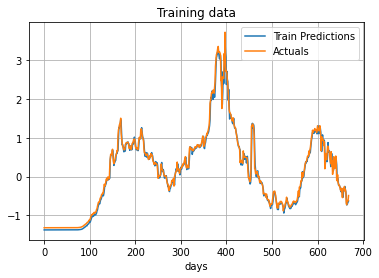

In [ ]:
train_predictions = modelRNN.predict( X_train ).flatten()
train_results     = pd.DataFrame( data = {'Train Predictions' : train_predictions, 'Actuals' : Y_train })

# Plot the predictions and actual data for the training set
train_results['days'] = train_results.reset_index().index.astype(np.float64)
train_results[["days","Train Predictions","Actuals"]].plot(x="days", grid=True, title='Training data')

Plot Validation Data vs Actual Values

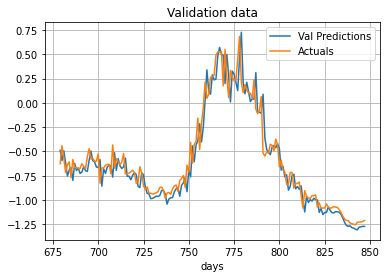

In [ ]:
val_predictions = modelRNN.predict(X_val).flatten()
val_results     = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':Y_val})

# Plot the predictions and actual data for the training set
val_results['days'] = [ i for i in range( train_len, len(new_df) )]
val_results[["days","Val Predictions","Actuals"]].plot(x="days", grid=True, title='Validation data')

In [ ]:
from sklearn.metrics import mean_squared_error
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, train_predictions)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_val, val_predictions)))

Train rmse: 0.1122108769136713
Validation rmse: 0.13736013723488757


Make a forecasting with a window of 10 days

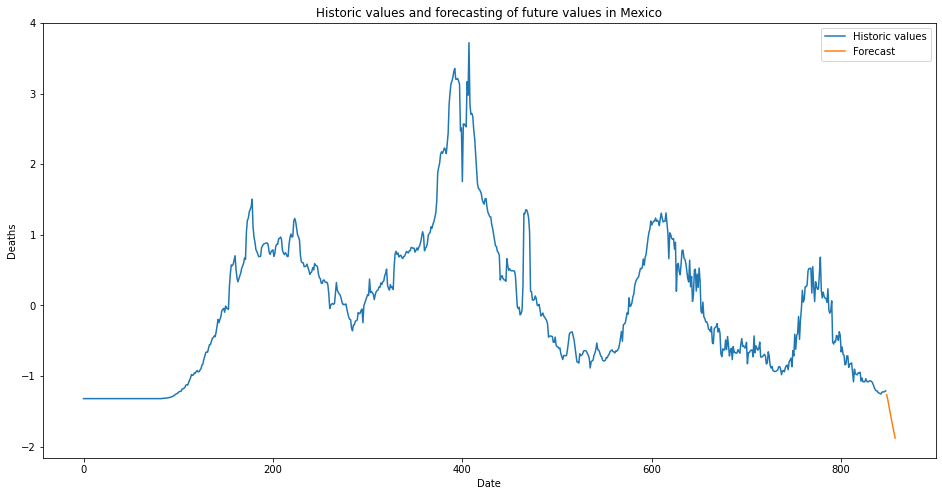

In [ ]:
df_forecasting = new_df

for i in range(1, window + 1,1):
    #Take the last 10 days from the dataframe:
    last_10_days = df_forecasting[-window:].values
    X_test = []
    X_test.append(last_10_days)
    X_test = tf.constant(X_test)
    #Reshape properly to be used by the model:
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
    pred_new_deaths = modelRNN.predict( X_test )
    df_forecasting = df_forecasting.append( pd.Series( float( pred_new_deaths ) ) ).copy()

df_forecasting = df_forecasting.reset_index( drop = True)
plt.figure(figsize=(16,8))
plt.title(f'Historic values and forecasting of future values in Mexico')
plt.xlabel('Date')
plt.ylabel('Deaths')
plt.plot(df_forecasting[:-window])
plt.plot(df_forecasting[-window:])
plt.legend(['Historic values','Forecast'])
plt.show()

#### LSTM

Long Short-Term Memory is an advanced version of recurrent neural network (RNN) architecture that was mainly introduced to handle situations where RNNs could fail. They are designed to model chronological sequences and their long-range dependencies more precisely than conventional RNNs, by taking into consideration the previous output and storing it in its memory for a short period of time (short-term memory).

One the major drawbacks of RNNs is that they fail to store information for longer periods of time. Moreover, there is no control over which part of the context needs to be kept, and how much of the past needs to be 'forgotten'. Thus, LSTM was created to satisfy those problems.

The basic difference between the architectures of RNNs and LSTMs is that the hidden layer of LSTM is a gated unit or gated cell. It consists of four layers that interact with one another in a way to produce the output of that cell along with the cell state. These two things are then passed onto the next hidden layer. LSTMs comprises of three logistic sigmoid gates and one tanh layer. These gates reduce limit the information that is passed through the cell by determining which part of the information will be needed (1) by the next cell, or which part will be discarded (0). 


Each LSTM cell has three inputs $h_{t-1}$, $C_{t-1}$, and $x_{t}$ (current input) and two outputs $h_{t}$ (hidden state at time t)  and $C_t$ (cell state or memory).

The first sigmoid layer is known as the forget gate as its output selects the amount of information of the previous cell to be included. The output is a number in [0,1] which is multiplied (point-wise) with the previous cell state $C_{t-1}$. 

The second sigmoid layer is the input gate that decides what new information is to be added to the cell. It includes a tanh layer that creates a vector $C_t$ of the candidate values. These two layers determine which information will be stored in the cell state.

The resulf of these two layers is addded with the result of the forget gate multiplied with the previous cell state to produce the current cell state.

The output of the cell is calculated using a sigmoid and a tanh layer. The sigmoid layer decides which part of the cell state will be present in the output whereas tanh layer shifts the output in the range of -1 and 1. Once multiplied, $h_t$ of the cell is generated.

There are some libraries such as ```tensorflow``` that already have an implementation for LSTM. 

In the cells below, LSTM is imported at ```from tensorflow.keras.layers import *```



In [ ]:
!pip install keras-tuner

     |████████████████████████████████| 133 kB 26.7 MB/s 


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from sklearn.metrics import mean_squared_error

We start by dividing our new_deaths_smoothed vector into training, test, and validation. Since we are working with a time series, we decide to choose the last X measurements as validation.

Additionally, the function `preprocessDataforLSTM` is created. This function defines how many samples will be given to the model per timestep. For example, using the default value = 5, during the first timestep, samples 0 through 4 will be introduced to the RNN. The next timestemp will provide samples 5 through 9 and so on. 

In [ ]:
def preprocessDataForLSTM(s, window_size=5):
  X = []
  y = []

  for i in range(window_size, len(s)):
    X.append(s[i-window_size:i])
    y.append(s[i])

  return np.array(X), np.array(y)

In [ ]:
# Divide the data in windows
X, y = preprocessDataForLSTM(df_normalized['new_deaths_smoothed'], window_size = 5)

# Create test, validation, and training tests
train_size       = int(np.round(len(y)*0.7))

validation_size  = int(np.round((len(y) - train_size) * 0.7))
test_start       = train_size + validation_size

X_train, y_train = X[:train_size], y[:train_size]
X_val  , y_val   = X[train_size:test_start], y[train_size:test_start]
X_test , y_test  = X[test_start:], y[test_start:]

In [ ]:
print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}, Validation size: {X_val.shape[0]}")

Train size: 590, Test size: 76, Validation size: 177


Genertion of the LSTM model.
The first model that we propose consists of three layers. The first layer is the LSTM layer that generates 50 output nodes. These nodes are connected to a fully connected layer and outputs 25 nodes. In the final layer we only have one node.



In [ ]:
def create_model(X_train, verbose=False):
  """
  Creates a model given a X_train of shape (n_samples, window_size)
  """
  model=Sequential()
  model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1],1)))
  model.add(Dense(25))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  if verbose:
    model.summary()
  return model

model = create_model(X_train)

We train the model

In [ ]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=10, verbose=1)

Epoch 1/10
59/59 [==============================] - 2s 10ms/step - loss: 0.3274 - val_loss: 0.0289
Epoch 2/10
59/59 [==============================] - 0s 5ms/step - loss: 0.0367 - val_loss: 0.0222
Epoch 3/10
59/59 [==============================] - 0s 8ms/step - loss: 0.0302 - val_loss: 0.0222
Epoch 4/10
59/59 [==============================] - 1s 10ms/step - loss: 0.0259 - val_loss: 0.0226
Epoch 5/10
59/59 [==============================] - 0s 7ms/step - loss: 0.0245 - val_loss: 0.0214
Epoch 6/10
59/59 [==============================] - 1s 9ms/step - loss: 0.0232 - val_loss: 0.0213
Epoch 7/10
59/59 [==============================] - 0s 8ms/step - loss: 0.0225 - val_loss: 0.0218
Epoch 8/10
59/59 [==============================] - 1s 10ms/step - loss: 0.0208 - val_loss: 0.0204
Epoch 9/10
59/59 [==============================] - 0s 8ms/step - loss: 0.0218 - val_loss: 0.0206
Epoch 10/10
59/59 [==============================] - 0s 7ms/step - loss: 0.0204 - val_loss: 0.0223


##### Performance

In this section, we show the performance of the trained model on the training, the test and the validation data.

**Training data**

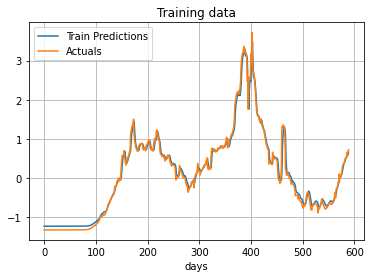

In [ ]:
train_predictions = model.predict(X_train).flatten()
train_results     = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})

# Plot the predictions and actual data for the training set
train_results['days'] = train_results.reset_index().index.astype(np.float64)
train_results[["days","Train Predictions","Actuals"]].plot(x="days", grid=True, title='Training data')

**Validation data**

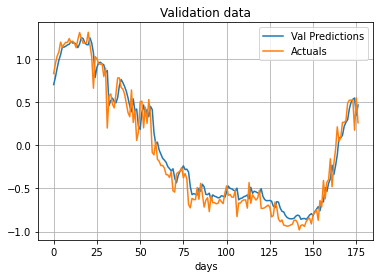

In [ ]:
val_predictions = model.predict(X_val).flatten()
val_results     = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})

# Plot the predictions and actual data for the training set
val_results['days'] = val_results.reset_index().index.astype(np.float64)
val_results[["days","Val Predictions","Actuals"]].plot(x="days", grid=True, title='Validation data')

**Test data**

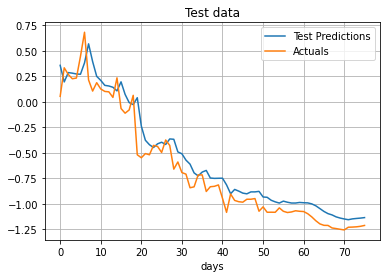

In [ ]:
test_predictions = model.predict(X_test).flatten()
test_results     = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})

# Plot the predictions and actual data for the training set
test_results['days'] = test_results.reset_index().index.astype(np.float64)
test_results[["days","Test Predictions","Actuals"]].plot(x="days", grid=True, title='Test data')

In [ ]:
print('Train rmse:', np.sqrt(mean_squared_error(y_train, train_predictions)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_val, val_predictions)))
print('Test rmse:', np.sqrt(mean_squared_error(y_test, test_predictions)))

Train rmse: 0.14178397947731472
Validation rmse: 0.14924653652965802
Test rmse: 0.1549860659925492


##### Parameter optimization

However, we observe in the validation and test data that there is a shift in the predicted values. In order to reduce that gap, we will find what is the window size that reduces the most the mean square error.

In [ ]:
train_err = []
val_err = []

window_sizes = [3, 5, 8, 10, 15, 20, 30, 40]

for window in window_sizes: 
  X, y = preprocessDataForLSTM(df_normalized['new_deaths_smoothed'], window_size=window)

  # Create test, validation, and training tests
  train_size       = int(np.round(len(y)*0.7))

  validation_size  = int(np.round((len(y) - train_size) * 0.7))
  test_start       = train_size + validation_size

  X_train, y_train = X[:train_size], y[:train_size]
  X_val  , y_val   = X[train_size:test_start], y[train_size:test_start]
  X_test , y_test  = X[test_start:], y[test_start:]
  print(X_train.shape)

  # create and fit the model
  model = create_model(X_train=X_train)
  model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=10, verbose=0)

  # predict values and append to list
  train_predictions = model.predict(X_train)
  val_predictions = model.predict(X_val)
  train_err.append(np.sqrt(mean_squared_error(y_train, train_predictions)))
  val_err.append(np.sqrt(mean_squared_error(y_val, val_predictions)))

(592, 3)
(590, 5)
(588, 8)
(587, 10)
(583, 15)
(580, 20)
(573, 30)
(566, 40)


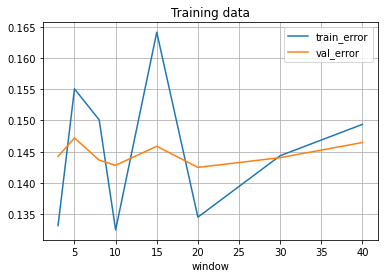

In [ ]:
tmp = pd.concat([pd.DataFrame(train_err, columns=['train_error']),
           pd.DataFrame(val_err ,columns=['val_error']),
           pd.DataFrame(window_sizes ,columns=['window'])], axis=1)

tmp[["window","train_error","val_error"]].plot(x="window", grid=True, title='Training data')

We now observe that there is not much to do in terms of the window size since the RMSE remains pretty close for all the different windows sizes that were tested. The next step is to create a Random Search of the model using the window size that generated the lowest validation error, which is between 15 and 20. 

Within the Random Search, the parameters that are being randomly selected are:
- The number of memory cells in the LSTM layer (between 30-100 with steps of 20)
- The number of hidden layers (between 1 and 4)
- The number of neurons in the hidden layers(between 50 and 200 with step of 50)
- The learning rate from Adam Optimizer (choose between 1e-2, 1e-3, 1e-4)

In [ ]:
X, y = preprocessDataForLSTM(df_normalized['new_deaths_smoothed'], window_size=15)


# Create test, validation, and training tests
train_size       = int(np.round(len(y)*0.7))

validation_size  = int(np.round((len(y) - train_size) * 0.7))
test_start       = train_size + validation_size

X_train, y_train = X[:train_size], y[:train_size]
X_val  , y_val   = X[train_size:test_start], y[train_size:test_start]
X_test , y_test  = X[test_start:], y[test_start:]

In [ ]:
def create_model_opt(hp):
  """
  Create a model that will be used to search the best combination of parameters
  """
  model = Sequential()
  model.add(LSTM(hp.Int('input_unit', min_value=30, max_value=100, step=20), activation='relu', input_shape=(15,1)))
  for i in range(hp.Int('n_layers', 1, 4)):
    model.add(Dense(hp.Int(f'fc_{i}_units', min_value=50, max_value=200, step=50)))
  model.add(Dense(1))
  model.compile(loss='mse', metrics=['mse'], optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])))
  return model

In [ ]:
tuner = RandomSearch(create_model_opt, objective='mse', max_trials=8, executions_per_trial=1, directory='/user2.json')

In [ ]:
tuner.search(x=X_train, y=y_train, epochs=30, batch_size=10, validation_data=(X_val,y_val))

Trial 8 Complete [00h 00m 19s]
mse: 0.016631335020065308

Best mse So Far: 0.01557612232863903
Total elapsed time: 00h 02m 49s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 90)                33120     
                                                                 
 dense (Dense)               (None, 100)               9100      
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 200)               10200     
                                                                 
 dense_3 (Dense)             (None, 50)                10050     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 67,571
Trainable params: 67,571
Non-traina

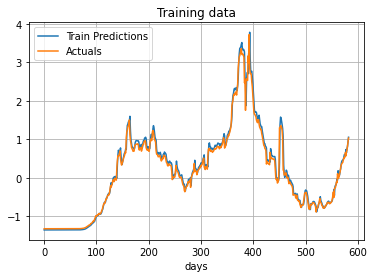

In [ ]:
train_predictions = best_model.predict(X_train).flatten()
train_results     = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})

val_predictions = best_model.predict(X_val).flatten()
val_results     = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})

# Plot the predictions and actual data for the training set
train_results['days'] = train_results.reset_index().index.astype(np.float64)
train_results[["days","Train Predictions","Actuals"]].plot(x="days", grid=True, title='Training data')

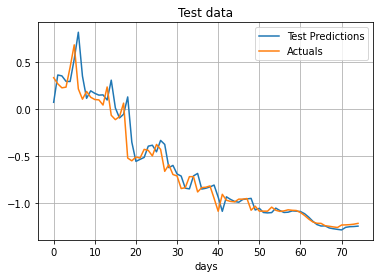

In [ ]:
test_predictions = best_model.predict(X_test).flatten()
test_results     = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})

# Plot the predictions and actual data for the training set
test_results['days'] = test_results.reset_index().index.astype(np.float64)
test_results[["days","Test Predictions","Actuals"]].plot(x="days", grid=True, title='Test data')

In [ ]:
print('Train rmse:', np.sqrt(mean_squared_error(y_train, train_predictions)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_val, val_predictions)))
print('Test rmse:', np.sqrt(mean_squared_error(y_test, test_predictions)))

Train rmse: 0.1349939243303873
Validation rmse: 0.16921657865280998
Test rmse: 0.14399779563469833


We can observe that we perform slightly better after the Random Search, but the performance is still around the same values. Since we are doing Random Search, if we execute the code again, we may have better or worse values, since the search is not exhaustive and we are limitting the combinations to a certain maximum number of combinations.

#### GRU 
GRU (Gated Recurrent Unit) aims to solve the vanishing gradient problem which comes with a standard recurrent neural network. GRU can also be considered as a variation on the LSTM because both are designed similarly and, in some cases, produce equally excellent results.
To solve the vanishing gradient problem of a standard RNN, GRU uses, so-called, update gate and reset gate. Basically, these are two vectors which decide what information should be passed to the output. The special thing about them is that they can be trained to keep information from long ago, without washing it through time or remove information which is irrelevant to the prediction.

The update gate is responsible for determining the amount of previous information that needs to pass along the next state. This is really powerful because the model can decide to copy all the information from the past and eliminate the risk of vanishing gradient. 
Reset gate

The reset gate is used from the model to decide how much of the past information is needed to neglect; in short, it decides whether the previous cell state is important or not.      

First, the reset gate comes into action it stores relevant information from the past time step into new memory content. Then it multiplies the input vector and hidden state with their weights. Next, it calculates element-wise multiplication between the reset gate and previously hidden state multiple. After summing up the above steps the non-linear activation function is applied and the next sequence is generated.     

In [ ]:
import numpy as np

from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU

In [ ]:
lookback = 30
horizon = 30
test_samples = 7
PREDICTORS = ['new_cases_smoothed','new_deaths_smoothed_per_million','new_cases_smoothed_per_million']

In [ ]:
# Divide the data in windows
X, y = preprocessDataForLSTM(df_normalized['new_deaths_smoothed'], window_size = 5)

# Create test, validation, and training tests
train_size       = int(np.round(len(y)*0.7))

validation_size  = int(np.round((len(y) - train_size) * 0.7))
test_start       = train_size + validation_size

X_train, y_train = X[:train_size], y[:train_size]
X_val  , y_val   = X[train_size:test_start], y[train_size:test_start]
X_test , y_test  = X[test_start:], y[test_start:]

In [ ]:
def create_model(X_train, verbose=False):
  model = Sequential()  
  model.add(GRU(50, activation='linear', input_shape=(X_train.shape[1],1)) )
  model.add(Dense(25))
  model.add(Dense(1))
  #model.add(Dense(horizon, activation='linear'))
  model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])  
  if verbose:
    model.summary()
  return model

model = create_model(X_train)

In [ ]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=10, verbose=1)

Epoch 1/10
59/59 [==============================] - 2s 10ms/step - loss: 0.2473 - accuracy: 0.0000e+00 - val_loss: 0.0250 - val_accuracy: 0.0000e+00
Epoch 2/10
59/59 [==============================] - 0s 5ms/step - loss: 0.0265 - accuracy: 0.0000e+00 - val_loss: 0.0209 - val_accuracy: 0.0000e+00
Epoch 3/10
59/59 [==============================] - 0s 5ms/step - loss: 0.0243 - accuracy: 0.0000e+00 - val_loss: 0.0233 - val_accuracy: 0.0000e+00
Epoch 4/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0225 - accuracy: 0.0000e+00 - val_loss: 0.0203 - val_accuracy: 0.0000e+00
Epoch 5/10
59/59 [==============================] - 0s 5ms/step - loss: 0.0220 - accuracy: 0.0000e+00 - val_loss: 0.0204 - val_accuracy: 0.0000e+00
Epoch 6/10
59/59 [==============================] - 0s 5ms/step - loss: 0.0204 - accuracy: 0.0000e+00 - val_loss: 0.0203 - val_accuracy: 0.0000e+00
Epoch 7/10
59/59 [==============================] - 0s 4ms/step - loss: 0.0197 - accuracy: 0.0000e+00 - val_los

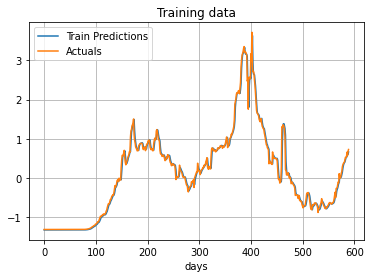

In [ ]:
train_predictions = model.predict(X_train).flatten()
train_results     = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})

# Plot the predictions and actual data for the training set
train_results['days'] = train_results.reset_index().index.astype(np.float64)
train_results[["days","Train Predictions","Actuals"]].plot(x="days", grid=True, title='Training data')

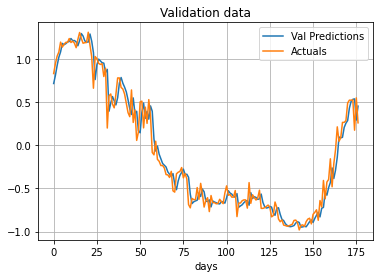

In [ ]:
val_predictions = model.predict(X_val).flatten()
val_results     = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})

# Plot the predictions and actual data for the training set
val_results['days'] = val_results.reset_index().index.astype(np.float64)
val_results[["days","Val Predictions","Actuals"]].plot(x="days", grid=True, title='Validation data')

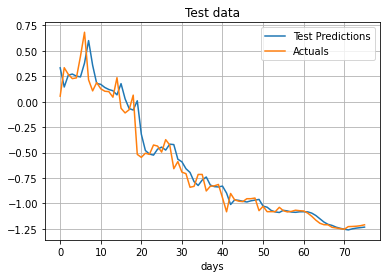

In [ ]:
test_predictions = model.predict(X_test).flatten()
test_results     = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})

# Plot the predictions and actual data for the training set
test_results['days'] = test_results.reset_index().index.astype(np.float64)
test_results[["days","Test Predictions","Actuals"]].plot(x="days", grid=True, title='Test data')

In [ ]:
print('Train rmse:', np.sqrt(mean_squared_error(y_train, train_predictions)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_val, val_predictions)))
print('Test rmse:', np.sqrt(mean_squared_error(y_test, test_predictions)))

Train rmse: 0.12879297037712514
Validation rmse: 0.14256440385462205
Test rmse: 0.12381753393041388


Parameter optimization

However, we observe in the validation and test data that there is a shift in the predicted values. In order to reduce that gap, we will find what is the window size that reduces the most the mean square error.

In [ ]:
train_err = []
val_err = []

window_sizes = [3, 5, 8, 10, 15, 20, 30, 40]

for window in window_sizes: 
  X, y = preprocessDataForLSTM(df_normalized['new_deaths_smoothed'], window_size=window)


  # Create test, validation, and training tests
  train_size       = int(np.round(len(y)*0.7))

  validation_size  = int(np.round((len(y) - train_size) * 0.7))
  test_start       = train_size + validation_size

  X_train, y_train = X[:train_size], y[:train_size]
  X_val  , y_val   = X[train_size:test_start], y[train_size:test_start]
  X_test , y_test  = X[test_start:], y[test_start:]
  print(X_train.shape)

  # create and fit the model
  model = create_model(X_train=X_train)
  model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=10, verbose=0)

  # predict values and append to list
  train_predictions = model.predict(X_train)
  val_predictions = model.predict(X_val)
  train_err.append(np.sqrt(mean_squared_error(y_train, train_predictions)))
  val_err.append(np.sqrt(mean_squared_error(y_val, val_predictions)))

(592, 3)
(590, 5)
(588, 8)
(587, 10)
(583, 15)
(580, 20)
(573, 30)
(566, 40)


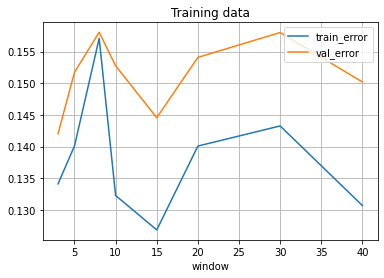

In [ ]:
tmp = pd.concat([pd.DataFrame(train_err, columns=['train_error']),
           pd.DataFrame(val_err ,columns=['val_error']),
           pd.DataFrame(window_sizes ,columns=['window'])], axis=1)

tmp[["window","train_error","val_error"]].plot(x="window", grid=True, title='Training data')

In [ ]:
X, y = preprocessDataForLSTM(df_normalized['new_deaths_smoothed'], window_size=15)


# Create test, validation, and training tests
train_size       = int(np.round(len(y)*0.7))

validation_size  = int(np.round((len(y) - train_size) * 0.7))
test_start       = train_size + validation_size

X_train, y_train = X[:train_size], y[:train_size]
X_val  , y_val   = X[train_size:test_start], y[train_size:test_start]
X_test , y_test  = X[test_start:], y[test_start:]

In [ ]:
def create_model_opt(hp):
  """
  Create a model that will be used to search the best combination of parameters
  """
  model = Sequential()
  model.add(GRU(hp.Int('input_unit', min_value=10, max_value=500, step=10), activation='linear', input_shape=(15,1)))
  for i in range(hp.Int('n_layers', 1, 8)):
    model.add(Dense(hp.Int(f'fc_{i}_units', min_value=5, max_value=300, step=40)))
  model.add(Dense(1))
  model.compile(loss='mse', metrics=['mse'], optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])))
  return model

In [ ]:
tuner = RandomSearch(create_model_opt, objective='mse', max_trials=8, executions_per_trial=1, directory='/user5.json')

In [ ]:
tuner.search(x=X_train, y=y_train, epochs=30, batch_size=10, validation_data=(X_val,y_val))

Trial 5 Complete [00h 01m 02s]
mse: 0.01628022827208042

Best mse So Far: 0.01599710062146187
Total elapsed time: 00h 04m 50s

Search: Running Trial #6

Value             |Best Value So Far |Hyperparameter
450               |280               |input_unit
7                 |7                 |n_layers
285               |245               |fc_0_units
0.001             |0.0001            |learning_rate
45                |245               |fc_1_units
125               |165               |fc_2_units
125               |285               |fc_3_units
285               |5                 |fc_4_units
45                |5                 |fc_5_units
205               |5                 |fc_6_units

Epoch 1/30
59/59 [==============================] - 6s 79ms/step - loss: 0.0896 - mse: 0.0896 - val_loss: 0.0237 - val_mse: 0.0237
Epoch 2/30
59/59 [==============================] - 4s 74ms/step - loss: 0.0258 - mse: 0.0258 - val_loss: 0.0235 - val_mse: 0.0235
Epoch 3/30
59/59 [======================

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

In [ ]:
train_predictions = best_model.predict(X_train).flatten()
train_results     = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})

val_predictions = best_model.predict(X_val).flatten()
val_results     = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})

# Plot the predictions and actual data for the training set
train_results['days'] = train_results.reset_index().index.astype(np.float64)
train_results[["days","Train Predictions","Actuals"]].plot(x="days", grid=True, title='Training data')

In [ ]:
test_predictions = best_model.predict(X_test).flatten()
test_results     = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})

# Plot the predictions and actual data for the training set
test_results['days'] = test_results.reset_index().index.astype(np.float64)
test_results[["days","Test Predictions","Actuals"]].plot(x="days", grid=True, title='Test data')

In [ ]:
print('Train rmse:', np.sqrt(mean_squared_error(y_train, train_predictions)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_val, val_predictions)))
print('Test rmse:', np.sqrt(mean_squared_error(y_test, test_predictions)))

As in the LTSM case, we can observe that we perform slightly better after the Random Search, but the performance is still around the same values. Since we are doing Random Search, if we execute the code again, we may have better or worse values, since the search is not exhaustive and we are limitting the combinations to a certain maximum number of combinations.

# Discussion
In this work different neural network structures and architectures were used in order to obtain a good model where each one of them learned how the COVID-19 has advanced in deaths in all this time. All three models achieve really good results with slightly differences but in overall they predict well the data. Because of the nature of the virus as well as other factors in world, making a forecast with a window size too large may cause problems with the data learned, so this solutions can only work with small window sizes. Different optimization techniques and optimizers were used to demonstrate how this algorithms can affect in the performance of the model, in general all the techniques that were used work pretty well to this kind of dataset. It is important to understand the complexity of these types of datasets, these datasets involve several features that have a weight on the outcome, but are not deterministic. For all three models, as we expected, the GRU architecture had an improvement compared to the LSTM and the simple RNN, however, it is more difficult to find the fitting hyperparameters that optimize the error of the predictions. 

# Conclusion

All three neural networks models show good results and work very well with the data that was given. The dataset that was used contain too many variable that have a huge potential to explore new things with this kind of algorithms and help in some way to the community with all this information that is being extracted every day. For purposes of this article it was only included Mexico in the models but with the results obtained it is very probable that training this models with the data of other countries might work as well. This work gave us a really good understanding in how we can construct robust models and how we can optimize them in order to obtain the best solution possible for our problem. We stronglely think that this kind of challenges are a good opportunity to put in practice all the novel models and technologies to have a better understanding of a complex problem, providing a better overview of the scenarios and predicting what will be the behavior of the outcomes in order to prevent, in the COVID-19 case, deaths and infections.

# References

1. Who coronavirus dashboard, https://covid19.who.int/
2. Kostadinov, S.: Understanding gru networks (2017),
https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be
3. Saavedra, G.: Time series forecasting (Nov 2021),
https://www.kaggle.com/code/georgesaavedra/time-series-forecasting/notebook
4. Saavedra, G.: Best covid-19 forecasting in us, uk and chile! (Mar 2022),
https://www.kaggle.com/code/georgesaavedra/best-covid-19-forecasting-in-us-
uk-and-chile
5. Schmitt, M.: How to fight covid-19 with machine learning: Data revenue,
https://www.datarevenue.com/en-blog/machine-learning-covid-19
6. Venkatachalam, M.: Recurrent neural networks (2022),
https://towardsdatascience.com/recurrent-neural-networks-d4642c9bc7ce